<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/plan_mnist_flat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


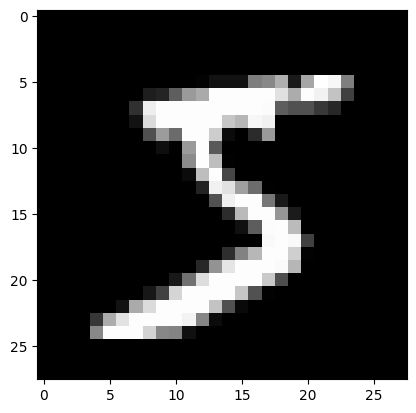

np.uint8(5)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray')
plt.show()
train_labels[0]

In [3]:
train_flat_images = train_images.reshape((60000, 28*28))
test_flat_images = test_images.reshape((10000, 28*28))
train_flat_images.shape

(60000, 784)

# Keras

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(train_flat_images, train_labels, epochs=5, batch_size=128)

test_loss, test_acc = model.evaluate(test_flat_images, test_labels)
print(f"test_loss:\t\t {test_loss:.4f}")
print(f"test_acc:\t\t {test_acc:.4f}")

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8310 - loss: 17.4345
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9527 - loss: 0.7921
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9663 - loss: 0.4643
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9719 - loss: 0.3735
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9761 - loss: 0.3081
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9613 - loss: 0.7774
test_loss:		 0.6776
test_acc:		 0.9653


# PyTorch

In [5]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Converter para tensores do PyTorch
train_flat_images_tensor = torch.tensor(train_flat_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Criar dataset e DataLoader
train_dataset = TensorDataset(train_flat_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Definição do modelo
class BasicTorchNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicTorchNN, self).__init__()
        self.fc1 = nn.Linear(784, 512)  # Supondo imagens de 28x28 (flattened para 784)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Inicialização do modelo
model = BasicTorchNN(len(set(train_labels)))
model.to(device)

# Definição do otimizador e da função de perda
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Loop de treinamento
epochs = 20
batch_size = 128

for epoch in range(epochs):
    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Avaliação do modelo
correct = 0
total = 0
criterion = torch.nn.CrossEntropyLoss()
test_flat_images_tensor = torch.tensor(test_flat_images, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

with torch.no_grad():
    outputs = model(test_flat_images_tensor)
    loss = criterion(outputs, test_labels_tensor)
    correct = (outputs.argmax(dim=1) == test_labels_tensor).sum().item()
    total = test_labels_tensor.size(0)
    test_acc = correct / total

print(f"test_loss: {loss.item():.4f}")
print(f"test_acc: {test_acc:.4f}")

Epoch 1/20, Loss: 1.9521
Epoch 2/20, Loss: 1.7942
Epoch 3/20, Loss: 1.7627
Epoch 4/20, Loss: 1.7527
Epoch 5/20, Loss: 1.7000
Epoch 6/20, Loss: 1.7357
Epoch 7/20, Loss: 1.6044
Epoch 8/20, Loss: 1.6408
Epoch 9/20, Loss: 1.6048
Epoch 10/20, Loss: 1.6067
Epoch 11/20, Loss: 1.5750
Epoch 12/20, Loss: 1.5340
Epoch 13/20, Loss: 1.4929
Epoch 14/20, Loss: 1.4765
Epoch 15/20, Loss: 1.4922
Epoch 16/20, Loss: 1.4818
Epoch 17/20, Loss: 1.4612
Epoch 18/20, Loss: 1.4716
Epoch 19/20, Loss: 1.4805
Epoch 20/20, Loss: 1.4699
test_loss: 1.4896
test_acc: 0.9714


# Keras Wrapped

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import numpy as np

def BasicKerasNN(num_classes):
  return keras.Sequential([
      layers.Dense(512, activation="relu"),
      layers.Dense(num_classes, activation="softmax")
  ])

class KerasWrappedNN(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = BasicKerasNN(len(self.labels))
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

modelo = KerasWrappedNN()
modelo.fit(train_flat_images, train_labels)
ypred = modelo.predict(test_flat_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8341 - loss: 17.8728
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9511 - loss: 0.7123
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9648 - loss: 0.4423
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.3040
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9760 - loss: 0.2881
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


0.9681

# PyTorch Wrapped

In [8]:
# Wrapper similar ao Scikit-Learn
class TorchWrappedNN:
    def __init__(self, epochs=20, batch_size=128):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.labels = None
        self.optimizer = None
        self.verbose = 1
        self.criterion = nn.CrossEntropyLoss()

    def fit(self, X, y):
        X = torch.from_numpy(X).float()
        self.labels, ids = np.unique(y, return_inverse=True)
        y_tensor = torch.tensor(ids, dtype=torch.long)  # Sem one-hot encoding

        num_classes = len(self.labels)
        self.model = BasicTorchNN(num_classes)
        self.model.to(device)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.0001)

        dataset = torch.utils.data.TensorDataset(X, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                images = images.view(images.size(0), -1)

                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

            if self.verbose > 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}")

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float().to(device)
            output = self.model(X_tensor).cpu().numpy()
            ypred = self.labels[output.argmax(axis=1)]
            return ypred

# Treinamento e avaliação
modelo = TorchWrappedNN()
modelo.fit(train_flat_images, train_labels)
ypred = modelo.predict(test_flat_images)

# Calcular acurácia
accuracy = accuracy_score(test_labels, ypred)
print(f"Acurácia do modelo: {accuracy:.4f}")


Epoch 1/20, Loss: 2.2320
Epoch 2/20, Loss: 2.0858
Epoch 3/20, Loss: 2.0946
Epoch 4/20, Loss: 1.8354
Epoch 5/20, Loss: 1.8258
Epoch 6/20, Loss: 1.7722
Epoch 7/20, Loss: 1.8975
Epoch 8/20, Loss: 1.7933
Epoch 9/20, Loss: 1.8237
Epoch 10/20, Loss: 1.7723
Epoch 11/20, Loss: 1.7519
Epoch 12/20, Loss: 1.8664
Epoch 13/20, Loss: 1.7413
Epoch 14/20, Loss: 1.6997
Epoch 15/20, Loss: 1.7075
Epoch 16/20, Loss: 1.6807
Epoch 17/20, Loss: 1.7104
Epoch 18/20, Loss: 1.7607
Epoch 19/20, Loss: 1.7323
Epoch 20/20, Loss: 1.6370
Acurácia do modelo: 0.7626


# Keras Pipeline

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

keraspipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("ann", KerasWrappedNN())
])

keraspipe.fit(train_flat_images, train_labels)
ypred = keraspipe.predict(test_flat_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8730 - loss: 0.4398
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9668 - loss: 0.1166
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9788 - loss: 0.0718
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9853 - loss: 0.0515
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9892 - loss: 0.0388
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9786

In [10]:
torchpipe = Pipeline([
    ("scaler", MinMaxScaler()),
    ("ann", TorchWrappedNN())
])

torchpipe.fit(train_flat_images, train_labels)
ypred = torchpipe.predict(test_flat_images)
accuracy_score(test_labels, ypred)

Epoch 1/20, Loss: 1.6190
Epoch 2/20, Loss: 1.5682
Epoch 3/20, Loss: 1.5591
Epoch 4/20, Loss: 1.5445
Epoch 5/20, Loss: 1.5304
Epoch 6/20, Loss: 1.5384
Epoch 7/20, Loss: 1.5227
Epoch 8/20, Loss: 1.5044
Epoch 9/20, Loss: 1.5307
Epoch 10/20, Loss: 1.4992
Epoch 11/20, Loss: 1.4807
Epoch 12/20, Loss: 1.5245
Epoch 13/20, Loss: 1.5145
Epoch 14/20, Loss: 1.5193
Epoch 15/20, Loss: 1.4792
Epoch 16/20, Loss: 1.5169
Epoch 17/20, Loss: 1.5048
Epoch 18/20, Loss: 1.4934
Epoch 19/20, Loss: 1.4745
Epoch 20/20, Loss: 1.5178


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9605

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class DividePor255(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.astype("float32") / 255

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("ann", KerasWrappedNN())
])

modelo.fit(train_flat_images, train_labels)
ypred = modelo.predict(test_flat_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8705 - loss: 0.4443
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9662 - loss: 0.1140
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9780 - loss: 0.0755
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9852 - loss: 0.0501
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9896 - loss: 0.0368
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9799

In [12]:
modelo = Pipeline([
    ("scaler", DividePor255()),
    ("ann", TorchWrappedNN())
])

modelo.fit(train_flat_images, train_labels)
ypred = modelo.predict(test_flat_images)
accuracy_score(test_labels, ypred)

Epoch 1/20, Loss: 1.5948
Epoch 2/20, Loss: 1.5991
Epoch 3/20, Loss: 1.5432
Epoch 4/20, Loss: 1.5803
Epoch 5/20, Loss: 1.5827
Epoch 6/20, Loss: 1.5489
Epoch 7/20, Loss: 1.5029
Epoch 8/20, Loss: 1.5399
Epoch 9/20, Loss: 1.5748
Epoch 10/20, Loss: 1.4922
Epoch 11/20, Loss: 1.4950
Epoch 12/20, Loss: 1.5487
Epoch 13/20, Loss: 1.4954
Epoch 14/20, Loss: 1.5336
Epoch 15/20, Loss: 1.4992
Epoch 16/20, Loss: 1.4979
Epoch 17/20, Loss: 1.4738
Epoch 18/20, Loss: 1.5120
Epoch 19/20, Loss: 1.5048
Epoch 20/20, Loss: 1.4921


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9603

In [13]:
class Shape2Flat(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.reshape((-1, 28 * 28))

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", Shape2Flat()),
    ("ann", KerasWrappedNN())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8770 - loss: 0.4334
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9658 - loss: 0.1170
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9800 - loss: 0.0716
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9856 - loss: 0.0483
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9892 - loss: 0.0382
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9801

In [14]:
modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", Shape2Flat()),
    ("ann", TorchWrappedNN())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/20, Loss: 1.5549
Epoch 2/20, Loss: 1.5991
Epoch 3/20, Loss: 1.5510
Epoch 4/20, Loss: 1.5309
Epoch 5/20, Loss: 1.5511
Epoch 6/20, Loss: 1.5206
Epoch 7/20, Loss: 1.5093
Epoch 8/20, Loss: 1.5270
Epoch 9/20, Loss: 1.5302
Epoch 10/20, Loss: 1.5307
Epoch 11/20, Loss: 1.5167
Epoch 12/20, Loss: 1.5491
Epoch 13/20, Loss: 1.5208
Epoch 14/20, Loss: 1.4829
Epoch 15/20, Loss: 1.5198
Epoch 16/20, Loss: 1.4833
Epoch 17/20, Loss: 1.5172
Epoch 18/20, Loss: 1.4958
Epoch 19/20, Loss: 1.5013
Epoch 20/20, Loss: 1.4789


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9592

# Convolutional Neural Networks

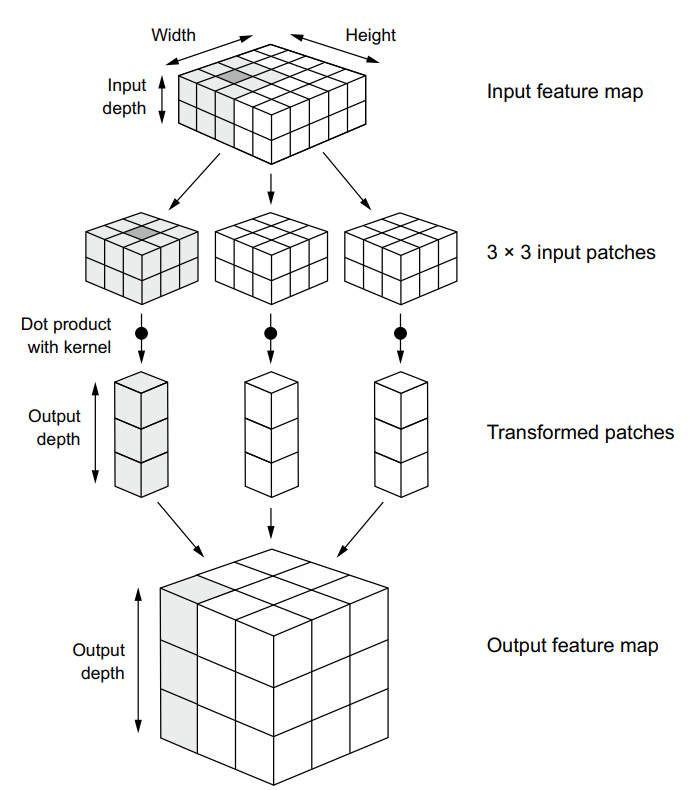

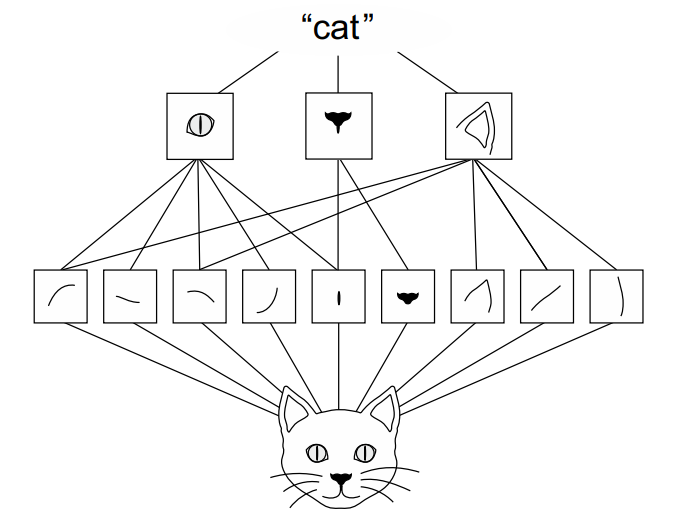

In [15]:
def KerasCNN2D(num_classes):
  return keras.Sequential([
    layers.Conv2D(4, 4, activation="relu"),
    layers.Flatten(),
    layers.Dense(512, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
  ])

class KerasWrappedCNN2D(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128):
    self.epochs = epochs
    self.batch_size = batch_size
  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = KerasCNN2D(yhot.shape[1])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self
  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

class Shape2Keras(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.reshape((-1, 28, 28, 1))

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", Shape2Keras()),
    ("ann", KerasWrappedCNN2D())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8531 - loss: 0.4684
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9745 - loss: 0.0844
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9854 - loss: 0.0475
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9912 - loss: 0.0313
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9920 - loss: 0.0240
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9846

In [16]:
# Definição da CNN em PyTorch
class TorchCNN2D(nn.Module):
    def __init__(self, num_classes):
        super(TorchCNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=1, padding=0)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 25 * 25, 512)  # Ajuste para manter compatibilidade com saída da convolução
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

# Wrapper semelhante ao Scikit-Learn
class TorchWrappedCNN2D:
    def __init__(self, epochs=5, batch_size=128):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.labels = None
        self.optimizer = None
        self.criterion = nn.CrossEntropyLoss()
        self.verbose = 1

    def fit(self, X, y):
        X = torch.from_numpy(X).float()
        self.labels, ids = np.unique(y, return_inverse=True)
        y_tensor = torch.tensor(ids, dtype=torch.long)

        num_classes = len(self.labels)
        self.model = TorchCNN2D(num_classes)
        self.model.to(device)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.001)

        dataset = torch.utils.data.TensorDataset(X, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

            if self.verbose > 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}")


    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float().to(device)
            output = self.model(X_tensor).cpu().numpy()
            ypred = self.labels[output.argmax(axis=1)]
            return ypred


class Shape2Torch(BaseEstimator, TransformerMixin):
  def fit(self, X, y):
    return self
  def transform(self, X, y=None):
    return X.reshape((-1, 1, 28, 28))


modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", Shape2Torch()),
    ("ann", TorchWrappedCNN2D())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)


Epoch 1/5, Loss: 1.5436
Epoch 2/5, Loss: 1.5240
Epoch 3/5, Loss: 1.4750
Epoch 4/5, Loss: 1.4986
Epoch 5/5, Loss: 1.4713


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9792

In [17]:
def KerasCNN2D(input_shape, output_shape):
  inputs = keras.Input(shape=input_shape)
  x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = layers.Flatten()(x)
  outputs = layers.Dense(output_shape, activation="softmax")(x)
  return keras.Model(inputs=inputs, outputs=outputs)

model = KerasCNN2D((28,28,1), 10)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,202 (407.04 KB)

 Trainable params: 104,202 (407.04 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
class KerasWrappedCNN2D(BaseEstimator, ClassifierMixin):
  def __init__(self, epochs=5, batch_size=128, modelFactory=KerasCNN2D):
    self.epochs = epochs
    self.batch_size = batch_size
    self.modelFactory = modelFactory

  def fit(self, X, y):
    self.labels, ids = np.unique(y, return_inverse=True)
    yhot = keras.utils.to_categorical(ids)
    self.model = self.modelFactory(X.shape[1:], yhot.shape[1])
    self.model.compile(optimizer="rmsprop",
                       loss="categorical_crossentropy",
                       metrics=["accuracy"])
    self.model.fit(X, yhot, epochs=self.epochs, batch_size=self.batch_size)
    return self

  def predict(self, X, y=None):
    probabilities = self.model.predict(X)
    ypred = self.labels[np.argmax(probabilities, axis=1)]
    return ypred

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", Shape2Keras()),
    ("ann", KerasWrappedCNN2D())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8493 - loss: 0.4667
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9829 - loss: 0.0570
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9896 - loss: 0.0341
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9918 - loss: 0.0264
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9934 - loss: 0.0207
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9899

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definição da CNN em PyTorch
class TorchCNN2D(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(TorchCNN2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, output_shape)  # Ajuste conforme necessário

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.softmax(self.fc(x), dim=1)
        return x

# Inicializando o modelo
input_shape = (1, 28, 28)  # Formato esperado para PyTorch (C, H, W)
output_shape = 10
model = TorchCNN2D(input_shape, output_shape)

# Exibir resumo do modelo
print(model)


TorchCNN2D(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)


In [22]:
# Wrapper semelhante ao Scikit-Learn
class TorchWrappedCNN2D:
    def __init__(self, epochs=5, batch_size=128, modelFactory=TorchCNN2D):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.labels = None
        self.optimizer = None
        self.criterion = nn.CrossEntropyLoss()
        self.verbose = 1
        self.modelFactory = modelFactory

    def fit(self, X, y):
        X = torch.from_numpy(X).float()
        self.labels, ids = np.unique(y, return_inverse=True)
        y_tensor = torch.tensor(ids, dtype=torch.long)

        num_classes = len(self.labels)
        self.model = self.modelFactory(X.shape[1:], num_classes)
        self.model.to(device)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.001)

        dataset = torch.utils.data.TensorDataset(X, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

            if self.verbose > 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}")


    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float().to(device)
            output = self.model(X_tensor).cpu().numpy()
            ypred = self.labels[output.argmax(axis=1)]
            return ypred

modelo = Pipeline([
    ("scaler", DividePor255()),
    ("reshape", Shape2Torch()),
    ("ann", TorchWrappedCNN2D())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5, Loss: 1.6157
Epoch 2/5, Loss: 1.5624
Epoch 3/5, Loss: 1.5486
Epoch 4/5, Loss: 1.5228
Epoch 5/5, Loss: 1.4624


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9906